## Intro

This notebook is a collection of analyses that investigate investment strategies for consumer loans. The data come from Lending Club's open statistics database. Each .csv file contains information for each loan (one row per loan). The information contains basic information about the loan (principle, interest rate, etc.) and about the borrower (rough geographic location, income, etc.). My goal here is to generate models that predict which loans will be most profitable to invest in. I will train the models on historic data, and then evaluate their efficacy with more recent loans. 


All code written by Charlie Hass 2017

In [3]:
#!pip install --user --upgrade pandas
#!pip install --upgrade --user sklearn
#!pip install --upgrade --user seaborn
#!pip install --upgrade --user matplotlib

In [535]:
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', None) 
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn.apionly as sns

from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import itertools

computer = "pro"

directories = {
    "pro": "/Users/charliehass/Dropbox/EfferenceCopy_DB/Project Files/LendingClub/",
    "air": "/Users/redteam/Dropbox/EfferenceCopy_DB/Project Files/LendingClub/"
}
data_dir = directories[computer]



def plot_confuse_mtx(cm, labels=None):
    plt.figure(figsize=(3,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix", fontsize=20)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.show()
    return None

def balance_groups(df_in):
    # upsample the minority classes in the training set
    df_counts = df_in.groupby(by="class")["dti"].count()
    df_counts.sort_values(inplace=True, ascending=False)

    N_max_class = df_counts.values[0]
    max_class = df_counts.index[0]
    class_names = sorted(df_counts.index)

    df_out = pd.DataFrame()
    for class_id in class_names:
        tmp_df = df_in.loc[df_in["class"]==class_id].copy()
        if class_id == max_class:
            pass
        else:
            tmp_df = resample(tmp_df,
                              replace=True,
                              n_samples=N_max_class
                             )
        df_out = df_out.append(tmp_df)
    return df_out

def compute_null_err_rate(df_in):
    df_counts = df_in.groupby(by="class")["dti"].count()
    df_counts.sort_values(inplace=True, ascending=False)
    N_max_class = df_counts.values[0]
    max_class = df_counts.index[0]
    null_err_rate = np.mean(df_in["class"] != max_class)
    return null_err_rate

In [540]:
# The code was removed by DSX for sharing.

In [ ]:
# save or open an existing model run
import dill as pickle

mode = "save"
filename = "logistic_clf_1219.pkl"

if mode == "save":
    pkldat = {"clf":clf, "train":train_df, "test":test_df, "features":features}
    pickle.dump(pkldat, open(filename, 'wb'))
elif mode == "open":
    pkldat = pickle.load(open(filename, 'rb'))
    clf = pkldat["clf"]
    train_df = pkldat["train_df"]
    test_df = pkldat["test_df"]
    features = pkldat["features"]
    del pkldat
    

In [542]:
# just look at the data frame
set(df_mature["zip_code"].map(len))

{3}

### Plot the return on investment seen by investors

The "internal rate of return" is simply the `total_interest` divided by the loan amount. If a single investor funded the entire loan amount, then the borrower would pay total_interest dollars in addition to the principle. Note: my calculation of IRR is not adjust for loan term (i.e., APY), and is simply how much the investor would earn (in %) if they held the loan 

The plot is a box plot. It shows the distribution of IRRs for each "grade" of loan. 

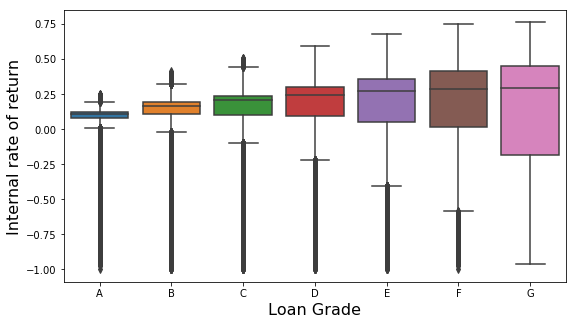

In [8]:
# Make a boxplot of IRRs for each grade of loan

plt.figure(figsize=(9,5))
sns.boxplot(x=df_mature["grade"], y=df_mature["irr"], order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.ylabel('Internal rate of return', fontsize=16)
plt.xlabel('Loan Grade', fontsize=16)
plt.show()

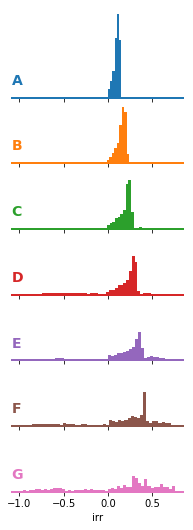

In [224]:
# Initialize the FacetGrid object
g = sns.FacetGrid(df_mature.sort_values(by="grade").copy(), row="grade", hue="grade", sharex=True)

# Draw the densities in a few steps
g.map(plt.hist, "irr", density=True, bins=50)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.patch.set_alpha(0)
    ax.text(0, .2, label, fontweight="bold", color=color, fontsize=14,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "irr")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)
g.fig.set_figheight(7)
g.fig.set_figwidth(3)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.show()

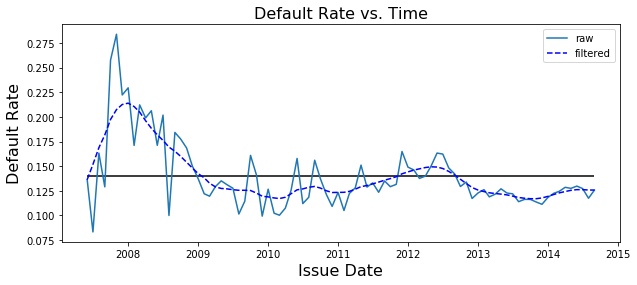

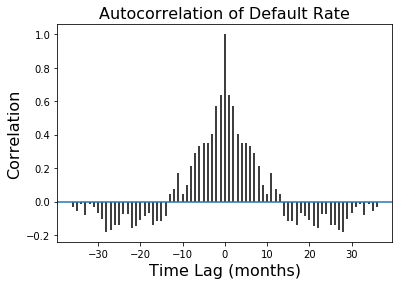

In [461]:
# Is there a relationship between default rate and time?
from pandas.plotting import autocorrelation_plot
from scipy.signal import filtfilt

df_ts = df_mature.loc[df_mature.grade<="D"].sort_values(by="issue_d").copy()
df_ts["is_default"] = df_ts["loan_status"] == "Charged Off"
df_ts["issue_d"] = pd.to_datetime(df_ts["issue_d"].copy(), format="%Y%m%d")

dft_rate = df_ts.sort_values(by="issue_d", ascending=True).groupby(by="issue_d")["is_default"].mean()



rates = dft_rate.values
filt_rates = filtfilt(np.ones(6)/6, 1, rates)
tt = dft_rate.index.values
plt.figure(figsize=(10,4))
plt.plot(tt, rates, label="raw")
plt.plot(tt, filt_rates, 'b--', label="filtered")
plt.hlines(y=np.mean(rates), xmin=tt[0], xmax=tt[-1])
plt.xlabel("Issue Date", fontsize=16)
plt.ylabel("Default Rate", fontsize=16)
plt.title("Default Rate vs. Time", fontsize=16)
plt.legend()
plt.show()

acor_vals = dft_rate.values - np.mean(dft_rate.values)
plt.figure()
plt.acorr(acor_vals, maxlags=36, normed=True)
plt.xlabel("Time Lag (months)", fontsize=16)
plt.ylabel("Correlation", fontsize=16)
plt.title("Autocorrelation of Default Rate", fontsize=16)
plt.show()

# create an issue_d_factor
tt_as_dtstr = pd.DataFrame(pd.to_datetime(tt))
tt_as_orig =  tt_as_dtstr.astype('str').replace('-', '', regex=True).astype('int')
tt_to_rate_lut = {k[0]:v for k,v in zip(tt_as_orig.values, filt_rates)}
df_mature["issue_d_factor"] = df_mature["issue_d"].copy().map(lambda x: tt_to_rate_lut[x])

### ideas for extra features

1. A representation of the preceeding default rate (for now just the default rate from the previous month. Note: this is not valid b/c the issue wouldn't know this beforehand. Need a non-retrospective method. as a fix, I could:
  * smooth the data with a differencing operator to estimate the trend in default rate
  * slide the curve "forward" in time so that a current loan application is being compared to the "default-rate-estimate" from 2yrs prior
  * This is actually a lagging indicator... so it may not be useful to force it as a "leading" indicator
1. Some representation of their location (if above average historically)
1. Change in home price indicies on a zip code basis
1. Change in wage data on a zip code basis



In [415]:
# default rate by zip code. Any information here?

dft_by_zip = df_mature.copy()
dft_by_zip["is_default"] = dft_by_zip["loan_status"] == "Charged Off"
dft_rate_by_zip = dft_by_zip.sort_values(by="zip_code").groupby(by="zip_code")["is_default"].mean().rename(columns={"is_default":"dft_rate"})
N_by_zip = dft_by_zip.sort_values(by="zip_code").groupby(by="zip_code")["is_default"].count().rename(columns={"is_default":"count"})

# correct for small sample sizes
dft_rate_by_zip.values[N_by_zip < 50] = np.mean(dft_rate_by_zip.values[N_by_zip > 50])

plt.figure()
plt.hist(dft_rate_by_zip.values, bins=100)
plt.show()

# add this information to the df_mature df as a potential feature
zip_2_rate_lut = {k:v for k,v in zip(dft_rate_by_zip.index, dft_rate_by_zip.values)}
df_mature["zip_factor"] = df_mature["zip_code"].copy().map(lambda x: zip_2_rate_lut[x])

### Relationship between actual and expected total payment

Loan borrowers may pay exactly the amount they owe (principle + interest), or they could pay more/less. Paying less is probably more common for 2 reasons:
1. Borrowers are eager to pay less, so they increase their monthly payments. Since they pay off the principle more quickly, they pay less in interest
1. The borrower defaults on the loan, and thus pays much much less than the expected amount.

In rare cases, the borrower may pay more than they were expected to. For example, if they miss a few payments, then they will pay off the priciple more slowly than anticipated (and thus pay more interest). 

Just to get an intuition for the relationship between `total_expected` and `total_actual` amounts, I'll just plot the two against each other in a 2D histogram. I'll do this separately for loans that were paid in full and those that were not. 

### IMPORTANT FINDING

My 2D histogram shows that the bulk of the density is below the main diagonal. This indicates that almost all of the borrower paid _less_ than anticipated. This would make the actual IRR _less_ than the expected IRR!! A good investor should not assume that their loan will provide the expected returns. Thus, when I'm trying to make a good investment portfolio, I need to:
1. Identify the borrowers that are likely to default
1. Identify the borrowers that are likely to pay as much as possible


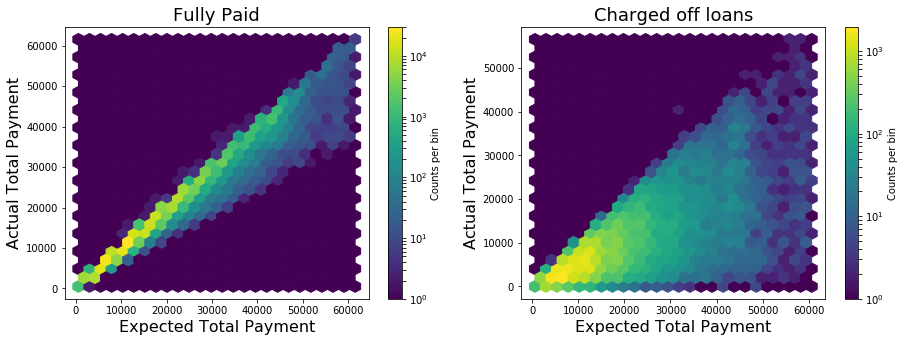

In [12]:
# use a joint plot to show diff b/w actual and predicted total payment
from matplotlib.colors import LogNorm

expected_total = df_mature["predicted_int"] + df_mature["funded_amnt"]

# Relationship b/w int_rate and %diff in IRR
l_paid = df_mature["loan_status"] == "Fully Paid"
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hexbin(expected_total[l_paid], df_mature.loc[l_paid, "total_pymnt"], gridsize=25, norm=LogNorm())
plt.xlabel("Expected Total Payment", fontsize=16)
plt.ylabel("Actual Total Payment", fontsize=16)
plt.colorbar(label="Counts per bin")
plt.title("Fully Paid", fontsize=18)

plt.subplot(1,2,2)
l_not_paid = df_mature["loan_status"] == "Charged Off"
plt.hexbin(expected_total[l_not_paid], df_mature.loc[l_not_paid, "total_pymnt"], gridsize=25, norm=LogNorm())
plt.colorbar(label="Counts per bin")
plt.xlabel("Expected Total Payment", fontsize=16)
plt.ylabel("Actual Total Payment", fontsize=16)
plt.title("Charged off loans", fontsize=18)
plt.show()


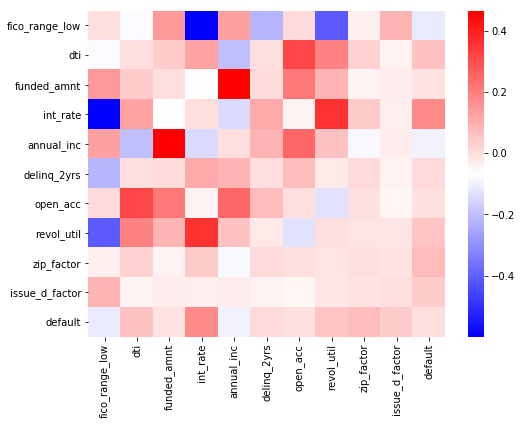

In [495]:
# look for correlations b/w the predictors and IRR
# here I'm just looking at the bool of IRR>0

df_new = df_mature.copy()
df_new["default"] = df_new["loan_status"] == "Charged Off" 

features = ["fico_range_low",
            "dti",
            "funded_amnt",
            "int_rate",
            "annual_inc",
            "delinq_2yrs",
            "open_acc",
            "revol_util",
            "zip_factor",
            "issue_d_factor",
            "default"
            ]

df_new = df_new[features]

corr_mtx = df_new[features].corr(method="spearman").values;

for idx in range(corr_mtx.shape[0]):
    corr_mtx[idx,idx] = 0

plt.figure(figsize=(8,6))
sns.heatmap(corr_mtx, 
            xticklabels=features,
            yticklabels=features,
            cmap=plt.cm.bwr)
plt.show()


## Implement a binary classifier

The goal here is to predict defaults. 

1. Split into training and testing datasets
1. Load in the `RandomForest` classifier from `sklearn`
1. Run the classifier on the training set
1. Generate predictions from the test data set


In [520]:
# Pandas based catagorical vars encoding
from sklearn.preprocessing import LabelEncoder

df_clf = df_mature.copy()

# add the class vars
df_clf["class"] = df_clf["loan_status"] == "Charged Off" 

# select out the quantitative feature columns
quant_cols = ["fico_range_low",
              "dti",
              "funded_amnt",
              "int_rate",
              "annual_inc",
              "delinq_2yrs",
              "open_acc",
              "revol_util",
              "installment",
              "term",
              "mths_since_last_delinq",
              "emp_length",
              "zip_factor",
              "issue_d_factor"]
ord_cols =  ['grade']
cat_cols = ['home_ownership', 'purpose']

df_clf = df_clf[quant_cols + ord_cols + cat_cols + ["class"]]

# OHE encoding for categorical vars
df_clf = pd.get_dummies(df_clf.copy(),
                             prefix=cat_cols,
                             columns=cat_cols,
                             sparse=False,
                             drop_first=False
                             )
# ordinal encoding
for col in ord_cols:
    label_encoder = LabelEncoder()
    df_clf.loc[:,col] = label_encoder.fit_transform(df_clf[col].copy())
    
df_clf.head()

,fico_range_low,dti,funded_amnt,int_rate,annual_inc,delinq_2yrs,open_acc,revol_util,installment,term,mths_since_last_delinq,emp_length,zip_factor,issue_d_factor,grade,class,home_ownership_mortgage,home_ownership_other,home_ownership_own,home_ownership_rent,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,730.0,22.87,27050.0,10.99,55000.0,0.0,14.0,61.2,885.46,36,0.0,1.0,0.153231,0.117783,1,False,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,720.0,4.62,12000.0,10.99,60000.0,0.0,15.0,24.0,392.81,36,0.0,4.0,0.127021,0.117783,1,False,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,755.0,2.49,4800.0,10.99,39600.0,0.0,3.0,16.1,157.13,36,0.0,2.0,0.121269,0.117783,1,False,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,715.0,13.03,12000.0,11.99,130000.0,0.0,9.0,67.0,398.52,36,0.0,1.0,0.121113,0.117783,1,False,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,660.0,8.40,7550.0,16.24,28000.0,0.0,4.0,72.0,266.34,36,0.0,3.0,0.140755,0.117783,2,False,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [521]:
# select a classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

classifier = 'logisticCV'

try:
    del clf
except:
    pass

if classifier == 'logistic':
    penalty = 'l1'
    solver_dict = {'l1':'saga', 'l2':'sag'}
    clf = LogisticRegression(penalty=penalty,
                             solver="liblinear", #solver_dict[penalty],
                             C=0.1,
                             fit_intercept=True,
                             max_iter=100,
                             n_jobs=-1)
    
elif classifier == 'logisticCV':
    penalty = 'l1'
    solver_dict = {'l1':'saga', 'l2':'sag'}
    clf = LogisticRegressionCV(Cs=15,
                               penalty=penalty,
                               solver=solver_dict[penalty],
                               fit_intercept=True,
                               cv=5, # i.e., 80-20 split for each fold
                               #scoring=f1_score,
                               tol=0.0001,
                               max_iter=100,
                               n_jobs=-1
                              )    
    
elif classifier == 'randomforests':
    clf = RandomForestClassifier(n_jobs=-1,
                                 criterion="gini", # 'gini', or 'entropy'
                                 n_estimators=100,
                                 oob_score=True,
                                 max_features='sqrt',
                                 max_depth=None,
                                 min_samples_split=2,
                                 bootstrap=True)


In [522]:
# split into training and test, apply a standard scalar to quant columns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split into train and test
train_df, test_df = train_test_split(df_clf.copy(), train_size=0.8, test_size=0.2, shuffle=True)

# balance classes in the train_df
train_df = balance_groups(train_df)

# define the feature columns (depend on feature encoder)
features = train_df.columns.values.tolist()
class_idx = features.index('class')
features.pop(class_idx);

# scale the features if logistic regression
if classifier in ["logistic", 'logisticCV']:
    scaler = StandardScaler()
    scaler.fit(train_df.loc[:, quant_cols])
    train_df.loc[:,quant_cols] = scaler.transform(train_df.loc[:, quant_cols].copy())
    test_df.loc[:,quant_cols] = scaler.transform(test_df.loc[:, quant_cols].copy())

/gpfs/fs01/user/s60d-dc390d4fc27c12-5c7936f598f4/.local/lib/python3.5/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Classification score on TRAINING data:  0.63017308385
Accuracy on TEST data:  0.626258821988
Null strategy accuracy on TEST rate:  0.86597127839
AUC score:  0.67337617765
F1 score:  0.310411505227


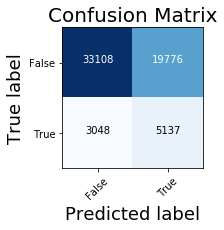

In [523]:
# train and test the binary classifier
from sklearn.metrics import roc_auc_score, f1_score

# fit the classifier
clf.fit(train_df[features], train_df["class"])


# evaluate the training classification
clf_score_train = clf.score(train_df[features], train_df["class"])
print("Classification score on TRAINING data: ", clf_score_train)

# determine the null error rate and AUC
predicted_class = clf.predict(test_df[features])
null_err_rate = compute_null_err_rate(test_df)
auc = roc_auc_score(test_df["class"], clf.predict_proba(test_df[features])[:,1])
f1 = f1_score(test_df["class"], predicted_class)

# print the classification score and the null rate
clf_score_test = clf.score(test_df[features], test_df["class"])
print("Accuracy on TEST data: ", clf_score_test)
print("Null strategy accuracy on TEST rate: ", 1-null_err_rate)
print("AUC score: ", auc)
print("F1 score: ", f1)

cmap=plt.cm.Blues
class_names = sorted(list(set(test_df["class"])))
confuse_mtx = confusion_matrix(test_df["class"], predicted_class, labels=class_names)
plot_confuse_mtx(confuse_mtx, labels=class_names)


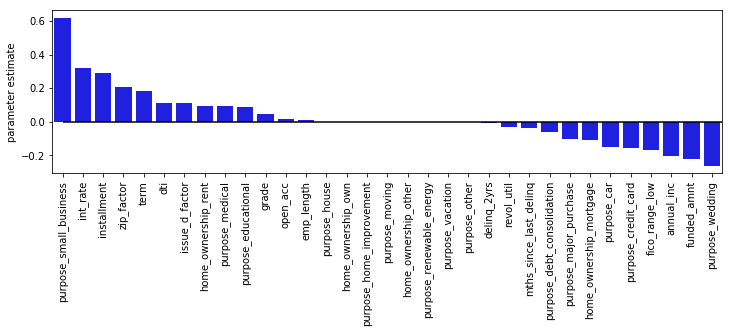

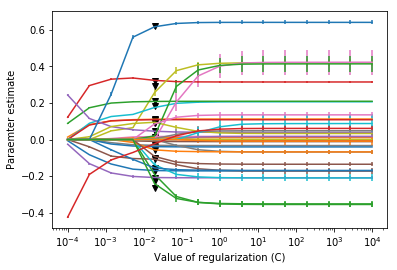

In [524]:
# visualize the features and how they influence the classification
if classifier == 'logistic':
    best_wts = clf.coef_[0]
elif classifier == 'logisticCV':
    best_wts = clf.coef_[0]
    all_wts = clf.coefs_paths_[True]
    all_Cs = clf.Cs_
elif classifier == 'randomforests':
    best_wts = clf.feature_importances_

df_wts = pd.DataFrame(best_wts, index=features, columns=["betas"]).sort_values(by="betas", ascending=False)

plt.figure(figsize=(12,3))
sns.barplot(x=df_wts.index, y=df_wts["betas"].values, label="weights", color="b")
plt.hlines(0, 0, df_wts.count())
plt.xticks(rotation="vertical")
plt.ylabel("parameter estimate")
plt.show()


if classifier == 'logisticCV':
    xbar_xfolds = np.mean(all_wts, axis=0)
    sigma_xfolds = np.std(all_wts, axis=0)
    for idx in range(xbar_xfolds.shape[1]):
        plt.errorbar(all_Cs, xbar_xfolds[:,idx], yerr=sigma_xfolds[:,idx])
    plt.plot(np.ones_like(best_wts)*clf.C_, best_wts, 'kv')
    plt.xscale('log')
    plt.xlabel('Value of regularization (C)')
    plt.ylabel('Paraemter estimate')
    plt.show()


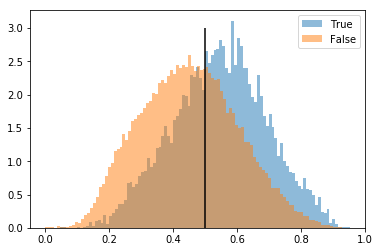

In [525]:
# look at the distribution of class probabilities for True and False predictions

test_p_dft = clf.predict_proba(test_df[features])
l_is_dft = test_df["class"] == True

plt.figure()
plt.hist(test_p_dft[l_is_dft, 1], bins=100, label="True", alpha=0.5, density=True)
plt.hist(test_p_dft[~l_is_dft, 1], bins=100, label="False", alpha=0.5, density=True)
plt.vlines(0.5, 0, 3)
plt.legend()
plt.show()


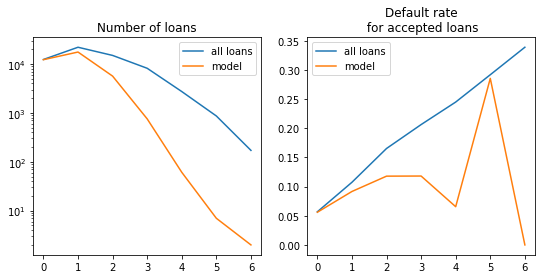

In [526]:
# compare naive strategy to using the mode
# 1) percentage of loans that would default based on each
#    method broken down by loan-grade

# add the predicted class to the test_df
test_df["pred_default"] = clf.predict(test_df[features])

# default strategy:
# group by loan grade, calculate percentage of bad loans
N_by_grade = test_df.sort_values(by="grade").groupby(by="grade")["grade"].count()
N_default_by_grade = test_df.sort_values(by="grade").groupby(by="grade")["class"].sum()
default_rate = N_default_by_grade / N_by_grade

# use the model to ignore predicted defaults
mod_picks_df = test_df.loc[~test_df.pred_default].copy()
N_by_grade_mod = mod_picks_df.sort_values(by="grade").groupby(by="grade")["grade"].count()
N_default_by_grade_mod = mod_picks_df.sort_values(by="grade").groupby(by="grade")["class"].sum()
default_rate_mod = N_default_by_grade_mod / N_by_grade_mod


fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.plot(range(0, len(N_by_grade)), N_by_grade, label="all loans")
plt.plot(range(0, len(N_by_grade_mod)), N_by_grade_mod, label="model")
plt.xticks(default_rate_mod.index)
plt.yscale('log')
plt.title("Number of loans")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(0, len(N_by_grade)), default_rate, label="all loans")
plt.plot(range(0, len(N_by_grade_mod)), default_rate_mod, label="model")
plt.xticks(default_rate_mod.index)
plt.title("Default rate\n for accepted loans")
plt.legend()
plt.show()



## Final thoughts

### Paths for improvement
1. A bare-bones implementation of Random Forests does an okay job with classifying some loans, but significant improvment needs to be made before this can be used for investment. Specifically, the classifier does not do a good job of excluding loans that will be negative-yielding
1. I should incorporate more of the features from the dataset. For example, categorical features like "loan grade" are not in the model but could yield additional predictive power.
1. I should try to incorporate new features. The dataset contains rough geographic location of the borrower. I could use economic trends in those locations to help predict default rates in this dataset. This could add a temporal element to the data to offset macro-trends that are currently obscured).
1. I could improve the Random Forests model (ntrees, etc).
1. I could consider different classification models
1. I should try to understand which features are most informative.

### Additional tests

So far, I only train/test on the loans that have loan-terms that have expired. In the dataset, there are loans that have terms ending in the future, but are considered "mature" because they are already paid off, or are in default. I could train on the "expired" loans and then test on the more recent "mature" loans. This would help evaluate if my classifier generalizes across time periods.

### Implement Knn regression for IRR

My goal is to predict which loans will be the most profitable. I could just predict the binary outcome of "fully paid" vs. "in default". However, this may not be as useful as predicting which loans will be most profitable. To see this, look at the histogram of investment return below. You can see that the distribution is multimodal. The loans that went into default have a negative IRR. The profitable loans have IRRs that are generally between 0 and 50%.

I'm going to try to regress IRR onto the predictor variables using K-nn regression

In [ ]:
# plot histogram of IRRs

plt.figure(figsize=(10, 5))
sns.distplot(df_mature["irr"], bins=150)
plt.xlabel("Internal Rate of Return", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.show()

In [19]:
df_in = train_df.copy()

# upsample the minority classes in the training set
df_counts = df_in.groupby(by="class")["dti"].count()
df_counts.sort_values(inplace=True, ascending=False)

N_max_class = df_counts.values[0]
max_class = df_counts.index[0]
class_names = sorted(df_counts.index)

df_out = pd.DataFrame()
for class_id in class_names:
    tmp_df = df_in.loc[df_in["class"]==class_id].copy()
    if class_id == max_class:
        pass
    else:
        tmp_df = resample(tmp_df,
                          replace=True,
                          n_samples=N_max_class
                         )
    df_out = df_out.append(tmp_df)

In [519]:
sorted(df_mature["zip_code"])

[7,
 8,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 1